# ЛАБОРАТОРНАЯ РАБОТА №9. ПОНИЖЕНИЕ РАЗМЕРНОСТИ. ОТБОР ПРИЗНАКОВ. ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ.

**ЗАДАНИЕ №1.**
1. Для выполнения задания №1 используйте датасеты для задачи классификации и регрессии.
2. С помощью классов библиотеки sklearn выполните понижение размерности (размерность выберите сами, можно разные) с использованием всех описанных методов (VarianceThreshold, SelectKBest, RFE, PCA, tSNE, Isomap).
3. Выберите две модели (одна - для регрессии и другая - для классификации). Обучите выбранные модели с использованием данных в пространстве низкой размерности - используйте результаты выполнения пункта 3 (не забудьте, что понижать нужно и X_train и X_test, но проще всего понижать X).
4. Сформулируйте вывод о том, какие методы понижения размерности лучше всего подходят для Ваших данных.


**ЗАДАНИЕ №2*.**
1. Самостоятельно реализуйте алгоритм PCA. На основе датасета для задачи классификации выполните понижение размерности до 2 (преобразуйте данные в двумерное пространство). Выполните визуализацию данных (точки на плоскости).
2. Выполнить кластеризацию преобразованных в пункте 1 данных с помощью Вашей реализации алгоритма KMeans из ЛР6.

In [17]:
import pandas as pd

**Существуют два подхода к понижению размерности данных:**
- отбор признаков (feature selection)
    - Отбор признаков с высокой дисперсией (VarianceThreshold)
    - Одномерный отбор признаков (SelectKBest) по их влиянию на целевую переменную
    - Рекурсивный отбор признаков (RFE) по их значимости
- выделение признаков (feature extraction)
    - линейный метод (PCA)
    - нелинейные методы (tSNE, Isomap)

Реализуем их для наших задач классификации и регрессии)

# Классификация

## Загрузка и предобработка данных

In [18]:
df_clf=pd.read_csv("C:/Users/seito/Jupyter Notebook/data/dataset4_with_EDA.csv")
df_clf

,Temperature,Humidity,TVOC,eCO2,Raw H2,Raw Ethanol,Pressure,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0
1,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,0
2,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,0
3,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,0
4,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60596,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,0
60597,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,0
60598,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,0
60599,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,0


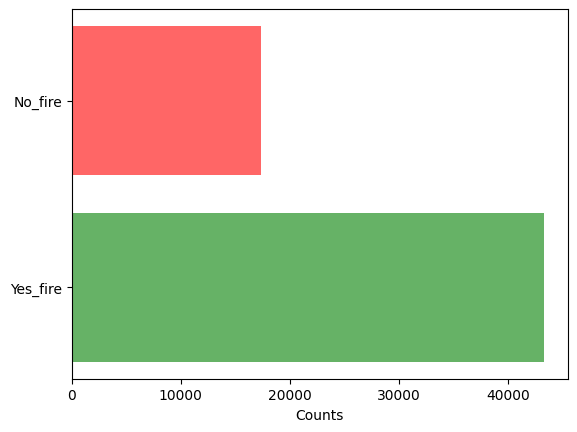

43293 17308


In [19]:
from matplotlib import pyplot as plt


yes_fire = df_clf[(df_clf['Fire Alarm'] != 0)]['Fire Alarm']
no_fire = df_clf[(df_clf['Fire Alarm'] == 0)]['Fire Alarm']

plt.barh(['Yes_fire', 'No_fire'], [yes_fire.count(), no_fire.count()], color = ['g', 'r'], alpha=0.6)
plt.xlabel('Counts')
plt.show()

print(yes_fire.count(), no_fire.count())

In [20]:
df_clf = df_clf.sort_values(by='Fire Alarm')
df_clf = df_clf[:(df_clf[df_clf['Fire Alarm'] == 0].shape[0]*2)]
df_clf=df_clf.sample(frac=1).reset_index(drop=True)

df_clf['Fire Alarm'].value_counts()

Fire Alarm
1    17308
0    17308
Name: count, dtype: int64

In [21]:
from sklearn.model_selection import train_test_split

y_clf = df_clf['Fire Alarm']
X_clf = df_clf.drop(['Fire Alarm'], axis=1)

X_clf.shape, y_clf.shape

((34616, 12), (34616,))

Тестировать модель будем с помощью градиентного бустинга

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def test_clf(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
  gb = GradientBoostingClassifier().fit(X_train, y_train)
  y_pred = gb.predict(X_test)
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

Посмотрим на оценку модели с исходным числом признаков

In [23]:
test_clf(X_clf, y_clf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3462
           1       1.00      1.00      1.00      3462

    accuracy                           1.00      6924
   macro avg       1.00      1.00      1.00      6924
weighted avg       1.00      1.00      1.00      6924

[[3462    0]
 [   0 3462]]


## Отбор признаков

Отбор признаков предполагает, что мы удаляем из набора данных признаки, которые практически не несут в себе достаточно информации об объектах. Мы оставляем в датасете только те признаки, которые раскрывают суть данных.

### 1. Отбираем признаки с высокой дисперсией

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clf)
X_scaled = pd.DataFrame(X_scaled, columns=X_clf.columns)
X_scaled.head()

,Temperature,Humidity,TVOC,eCO2,Raw H2,Raw Ethanol,Pressure,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
0,0.183744,0.681663,0.003383,0.000000,0.791388,0.777614,0.968809,0.000043,0.000014,0.000069,0.000013,4.995598e-07
1,0.599475,0.623798,0.000000,0.000000,0.754067,0.759068,0.987901,0.000010,0.000004,0.000017,0.000003,1.332159e-07
2,0.572858,0.636984,0.020300,0.000218,0.717384,0.672903,0.872350,0.000106,0.000035,0.000170,0.000031,1.232247e-06
3,0.541738,0.661496,0.000000,0.000034,0.615630,0.717545,0.994339,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,0.157127,0.588427,0.000333,0.000000,0.824880,0.803053,0.980353,0.000159,0.000052,0.000255,0.000047,1.831719e-06


In [9]:
X_scaled.describe()

,Temperature,Humidity,TVOC,eCO2,Raw H2,Raw Ethanol,Pressure,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
count,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,3.461600e+04
mean,0.492588,0.549301,0.045523,0.006953,0.724172,0.747145,0.828925,0.011575,0.006618,0.013329,0.006386,4.282145e-03
std,0.181081,0.166891,0.170789,0.042226,0.107872,0.123475,0.183996,0.081843,0.054531,0.089614,0.053432,4.483743e-02
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.407841,0.531454,0.001017,0.000000,0.680702,0.676186,0.730381,0.000063,0.000021,0.000101,0.000019,7.659916e-07
50%,0.567855,0.589978,0.003467,0.000000,0.724721,0.762350,0.874903,0.000121,0.000040,0.000194,0.000036,1.398767e-06
75%,0.595070,0.651257,0.019883,0.000302,0.785646,0.829312,0.972250,0.000141,0.000046,0.000226,0.000042,1.631895e-06
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00


In [10]:
X_scaled.var()

Temperature    0.032790
Humidity       0.027853
TVOC           0.029169
eCO2           0.001783
Raw H2         0.011636
Raw Ethanol    0.015246
Pressure       0.033855
PM1.0          0.006698
PM2.5          0.002974
NC0.5          0.008031
NC1.0          0.002855
NC2.5          0.002010
dtype: float64

In [11]:
from sklearn.feature_selection import VarianceThreshold


vt = VarianceThreshold(0.01)
X_vt = vt.fit_transform(X_scaled)
print(X_vt.shape)
test_clf(X_vt, y_clf)

(34616, 6)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3499
           1       1.00      1.00      1.00      3425

    accuracy                           1.00      6924
   macro avg       1.00      1.00      1.00      6924
weighted avg       1.00      1.00      1.00      6924

[[3498    1]
 [   2 3423]]


Качество модели не уменьшилось, хотя удалилось половину столбцов!

### 2. Одномерный отбор признаков

Одномерный отбор признаков предполагает, что для каждого признака оценивается степень его влияния на целевую переменную. Признаки с небольшим влиянием удаляются. 

In [14]:
from sklearn.feature_selection import SelectKBest

skb = SelectKBest(k=4)
X_skb = skb.fit_transform(X_clf, y_clf)
test_clf(X_skb, y_clf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3499
           1       1.00      1.00      1.00      3425

    accuracy                           1.00      6924
   macro avg       1.00      1.00      1.00      6924
weighted avg       1.00      1.00      1.00      6924

[[3494    5]
 [  14 3411]]


In [15]:
X_skb = pd.DataFrame(X_skb, columns=skb.get_feature_names_out())
X_skb

,Humidity,TVOC,Raw Ethanol,Pressure
0,54.68,203.0,20055.0,939.580
1,50.95,0.0,19942.0,939.752
2,51.80,1218.0,19417.0,938.711
3,53.38,0.0,19689.0,939.810
4,48.67,20.0,20210.0,939.684
...,...,...,...,...
34611,13.96,783.0,20422.0,936.823
34612,51.19,1153.0,19449.0,938.923
34613,40.92,101.0,20631.0,937.487
34614,50.57,83.0,20127.0,939.632


### 3. Рекурсивный отбор признаков

Рекурсивный отбор признаков предполагает обучение множества моделей. Сначала модель обучается на всех признаках, а затем мы начинаем исключать из модели признаки с низкой значимостью. Делаем это до тех пор, пока не останется столько признаков, сколько нам нужно получить

Важный момент состоит в том, каким образом мы исключаем признаки. Происходит это на основе значения значимости признака. Обученные регрессионные модели и деревья решений хранят информацию о значимости признаков (коэффициенты в линейных моделях и значения значимости признаков у деревьев). Можно отсортировать признаки по этим значениям и производить отбор

In [16]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X_clf, y_clf)

rfe = RFE(estimator=tree, n_features_to_select=3, step=1).fit(X_clf, y_clf)
X_rfe = pd.DataFrame(rfe.transform(X_clf), columns=rfe.get_feature_names_out())
X_rfe

,Temperature,Pressure,NC0.5
0,-6.954,939.580,4.25
1,27.111,939.752,1.05
2,24.930,938.711,10.47
3,22.380,939.810,0.00
4,-9.135,939.684,15.68
...,...,...,...
34611,13.822,936.823,6.79
34612,24.980,938.923,12.79
34613,-7.839,937.487,11.71
34614,-2.616,939.632,14.97


In [17]:
test_clf(X_rfe, y_clf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3499
           1       1.00      1.00      1.00      3425

    accuracy                           1.00      6924
   macro avg       1.00      1.00      1.00      6924
weighted avg       1.00      1.00      1.00      6924

[[3498    1]
 [   2 3423]]


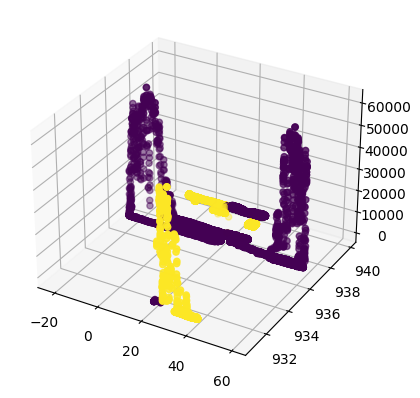

In [21]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_rfe['Temperature'], X_rfe['Pressure'], X_rfe['NC0.5'], c=y_clf);

## Выделение признаков

### Метод главных компонент (Principal Component Analysis - PCA) 

Основные шаги алгоритма PCA:

- **Стандартизация данных:** Прежде чем приступить к вычислению главных компонент, важно стандартизировать данные, приводя их к нулевому среднему и единичной дисперсии. Это важно, потому что признаки с разными масштабами могут исказить результаты PCA.
- **Вычисление ковариационной матрицы:** После стандартизации данных мы вычисляем ковариационную матрицу C.
- **Вычисление собственных векторов и собственных значений:** Следующим шагом является вычисление собственных векторов и собственных значений ковариационной матрицы.
- **Сортировка главных компонент:** Главные компоненты сортируются в порядке убывания собственных значений. Это позволяет нам выбрать наиболее информативные компоненты.
- **Проекция данных на главные компоненты:** Наконец, мы проецируем исходные данные на новый базис, образованный главными компонентами. Это позволяет нам снизить размерность данных.

Главные компоненты, полученные на последнем шаге, представляют собой новые признаки, которые можно использовать для анализа или обучения моделей машинного обучения.

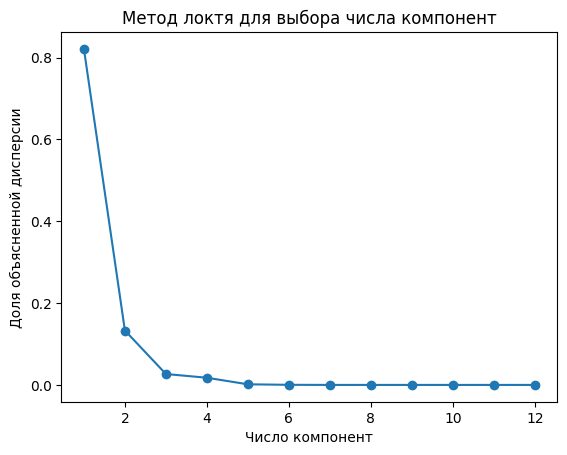

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Создаем экземпляр PCA
pca = PCA()

# Обучаем PCA на данный X
pca.fit(X_clf)

# Строим график объясненной дисперсии
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Число компонент")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод локтя для выбора числа компонент")
plt.show()

Оптимальное число компонент для PCA - 2 штуки

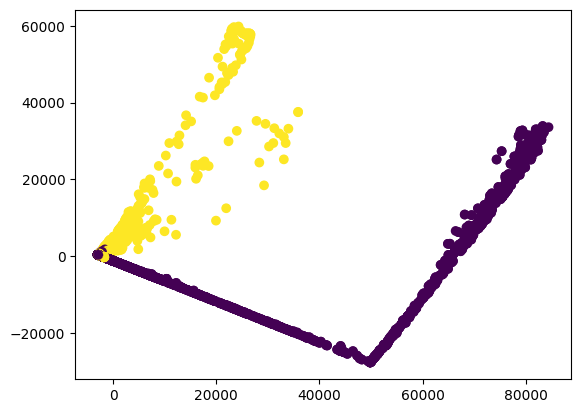

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clf, y_clf)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_clf);

In [24]:
sum(pca.explained_variance_ratio_)

0.954035454532868

Потеряли всего 5% информации, хотя снизили чило предикторов в 6 раз👍

In [25]:
test_clf(X_pca, y_clf)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      3499
           1       0.97      0.85      0.91      3425

    accuracy                           0.91      6924
   macro avg       0.92      0.91      0.91      6924
weighted avg       0.92      0.91      0.91      6924

[[3415   84]
 [ 509 2916]]


### Нелинейные методы выделения признаков (TSNE, Isomap)

c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


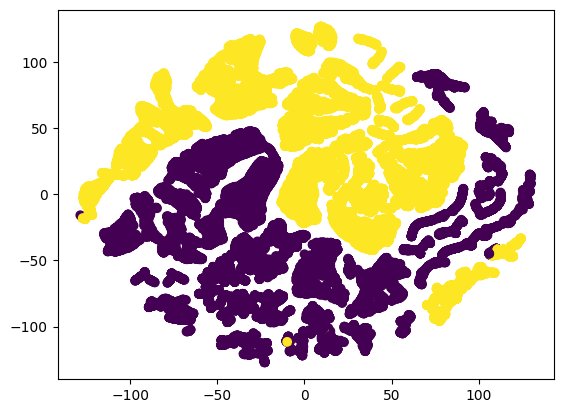

In [26]:
from sklearn.manifold import TSNE, Isomap

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_clf);

In [27]:
test_clf(X_tsne, y_clf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3499
           1       1.00      1.00      1.00      3425

    accuracy                           1.00      6924
   macro avg       1.00      1.00      1.00      6924
weighted avg       1.00      1.00      1.00      6924

[[3498    1]
 [   8 3417]]


c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 22 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a cs

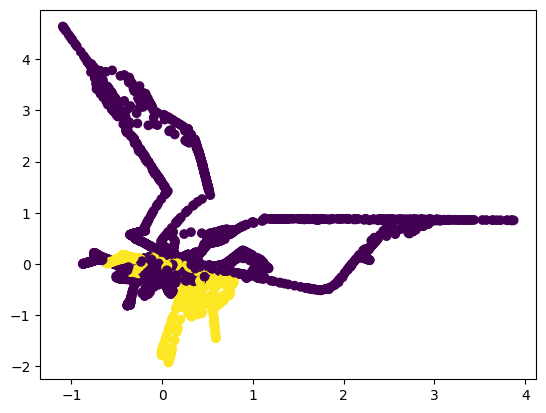

In [28]:
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_scaled)

plt.scatter(X_isomap[:,0], X_isomap[:,1], c=y_clf);

За 13.5 минут мы получили пчелу, спасибо 🐝🐝🐝 

In [122]:
test_clf(X_isomap, y_clf)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3499
           1       0.90      0.92      0.91      3425

    accuracy                           0.91      6924
   macro avg       0.91      0.91      0.91      6924
weighted avg       0.91      0.91      0.91      6924

[[3141  358]
 [ 266 3159]]


### Обучение модели с использованием данных в пространстве низкой размерности 

График с преобразованием t-SNE выглядит прикольно (как 🧠), обучим на этих данных модель DBSCAN

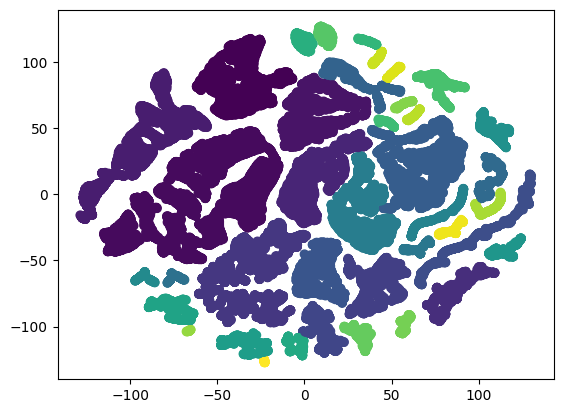

In [47]:
from sklearn.cluster import DBSCAN
import numpy as np

dbscan = DBSCAN(eps = 5, min_samples=10).fit(X_tsne)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=dbscan.labels_)

In [51]:
from sklearn.metrics import silhouette_score, rand_score

print('\tВнутренние метрики: ')
print(f'Силуэт: {silhouette_score(X_tsne, dbscan.labels_)}')
print('\n\tВнешние метрики: ')
print(f'Индекс Rand: {rand_score(y_clf, dbscan.labels_)}')

	Внутренние метрики: 
Силуэт: 0.1907239705324173

	Внешние метрики: 
Индекс Rand: 0.5737615837669747


c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


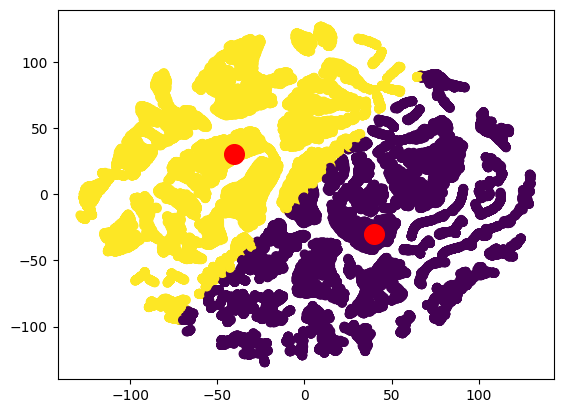

In [52]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(X_tsne)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=200);

In [49]:
silhouette_score(X_tsne, kmeans.labels_)

0.34606105

# Регрессия

## Загрузка и предобработка данных

In [53]:
df_reg=pd.read_csv("C:/Users/seito/Jupyter Notebook/data/dataset3_EDA+.csv")
df_reg

,Price,Area,Latitude,Longitude,Bedrooms,Bathrooms,Balcony,Neworold,Parking,Furnished_Status,Lift,Type_Of_Building
0,2240.0,629.0,19.032800,72.896357,2,2,0,1,0,0,0,0
1,3500.0,974.0,19.032800,72.896357,3,2,0,1,0,0,0,0
2,3170.0,968.0,19.085600,72.909277,3,3,0,1,0,0,0,0
3,1870.0,629.0,19.155756,72.846862,2,2,2,1,1,0,1,0
4,1350.0,1090.0,19.177555,72.849887,2,2,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5266,1950.0,810.0,19.138320,72.810020,2,2,0,0,0,1,0,0
5267,2200.0,1400.0,19.221920,72.854250,3,3,1,0,1,0,1,0
5268,2000.0,750.0,19.144320,72.824111,2,2,0,0,0,0,0,0
5269,1100.0,700.0,19.047201,72.872225,2,2,0,0,0,2,0,0


In [54]:
y_reg = df_reg['Price']
X_reg = df_reg.drop(['Price'], axis=1)

X_reg.shape, y_reg.shape

((5271, 11), (5271,))

Тестировать модель будем с помощью полиномиальной регрессии 2 степени

In [60]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def test_reg(X, y):
    X_p = PolynomialFeatures(2).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_p, y, test_size=0.2)
    lr = LinearRegression().fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'R^2: {r2_score(y_test, y_pred)}')

Посмотрим на оценку модели с исходным числом признаков

In [61]:
test_reg(X_reg, y_reg)

MSE: 304425.25893469533
R^2: 0.6586741617045864


## Отбор признаков

### 1. Отбираем признаки с высокой дисперсией

In [65]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reg)
X_scaled = pd.DataFrame(X_scaled, columns=X_reg.columns)
X_scaled.head()

,Area,Latitude,Longitude,Bedrooms,Bathrooms,Balcony,Neworold,Parking,Furnished_Status,Lift,Type_Of_Building
0,0.098669,0.264033,0.320629,0.000000,0.250,0.00,1.0,0.0,0.0,0.0,0.0
1,0.368833,0.264033,0.320629,0.166667,0.250,0.00,1.0,0.0,0.0,0.0,0.0
2,0.364135,0.351665,0.349746,0.166667,0.375,0.00,1.0,0.0,0.0,0.0,0.0
3,0.098669,0.468101,0.209090,0.000000,0.250,0.25,1.0,1.0,0.0,1.0,0.0
4,0.459671,0.504280,0.215907,0.000000,0.250,0.00,1.0,0.0,0.0,0.0,0.0


In [66]:
X_scaled.describe()

,Area,Latitude,Longitude,Bedrooms,Bathrooms,Balcony,Neworold,Parking,Furnished_Status,Lift,Type_Of_Building
count,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000,5271.000000
mean,0.388390,0.491401,0.264960,0.043097,0.277319,0.094337,0.114210,0.358755,0.250711,0.358755,0.069626
std,0.205207,0.178429,0.135536,0.080274,0.058092,0.152733,0.318096,0.479681,0.373311,0.479681,0.254540
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.232576,0.376203,0.185247,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.361785,0.475951,0.241212,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.506656,0.583485,0.301067,0.000000,0.250000,0.125000,0.000000,1.000000,0.500000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
X_scaled.var()

Area                0.042110
Latitude            0.031837
Longitude           0.018370
Bedrooms            0.006444
Bathrooms           0.003375
Balcony             0.023327
Neworold            0.101185
Parking             0.230094
Furnished_Status    0.139361
Lift                0.230094
Type_Of_Building    0.064791
dtype: float64

In [82]:
vt = VarianceThreshold(0.03)
X_vt = vt.fit_transform(X_scaled)
print(X_vt.shape)
test_reg(X_vt, y_reg)

(5271, 7)
MSE: 388380.97601587465
R^2: 0.5621844274302494


Качество модели чуть-чуть ухудшилось, хотя мы убрали 4 признака

### 2. Одномерный отбор признаков

In [97]:
skb = SelectKBest(k=4)
X_skb = skb.fit_transform(X_reg, y_reg)
test_reg(X_skb, y_reg)

MSE: 370716.0342665493
R^2: 0.5831158819687371


С 4 признаками даже лучше, чем с 7!

In [99]:
X_skb = pd.DataFrame(X_skb, columns=skb.get_feature_names_out())
X_skb

,Area,Latitude,Bedrooms,Bathrooms
0,629.0,19.032800,2.0,2.0
1,974.0,19.032800,3.0,2.0
2,968.0,19.085600,3.0,3.0
3,629.0,19.155756,2.0,2.0
4,1090.0,19.177555,2.0,2.0
...,...,...,...,...
5266,810.0,19.138320,2.0,2.0
5267,1400.0,19.221920,3.0,3.0
5268,750.0,19.144320,2.0,2.0
5269,700.0,19.047201,2.0,2.0


### 3. Рекурсивный отбор признаков

In [101]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor().fit(X_reg, y_reg)

rfe = RFE(estimator=tree, n_features_to_select=3, step=1).fit(X_reg, y_reg)
X_rfe = pd.DataFrame(rfe.transform(X_reg), columns=rfe.get_feature_names_out())
X_rfe

,Area,Latitude,Longitude
0,629.0,19.032800,72.896357
1,974.0,19.032800,72.896357
2,968.0,19.085600,72.909277
3,629.0,19.155756,72.846862
4,1090.0,19.177555,72.849887
...,...,...,...
5266,810.0,19.138320,72.810020
5267,1400.0,19.221920,72.854250
5268,750.0,19.144320,72.824111
5269,700.0,19.047201,72.872225


In [107]:
test_reg(X_rfe, y_reg)

MSE: 337567.42074302
R^2: 0.6133934434897825


Кайф, с каждым разом все лучше, хотя число признаков уменьшается)

## Выделение признаков

### Главные компоненты (PCA)

Рискнем на 2 компоненты

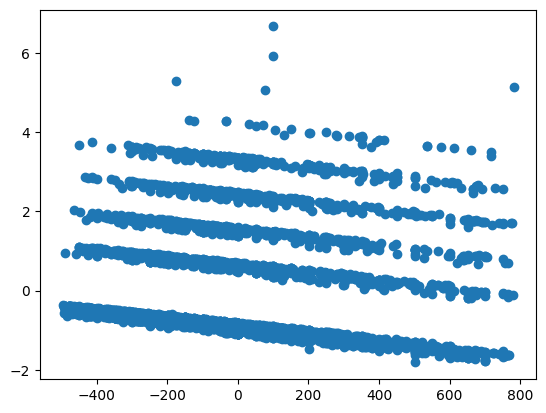

In [113]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_reg, y_reg)

plt.scatter(X_pca[:,0], X_pca[:,1]);

In [114]:
sum(pca.explained_variance_ratio_)

0.9999831534415782

In [116]:
test_reg(X_pca, y_reg)

MSE: 730486.7239038396
R^2: 0.21849968183750812


Мы потеряли точность (((((

### Нелинейные методы выделения признаков (TSNE, Isomap)

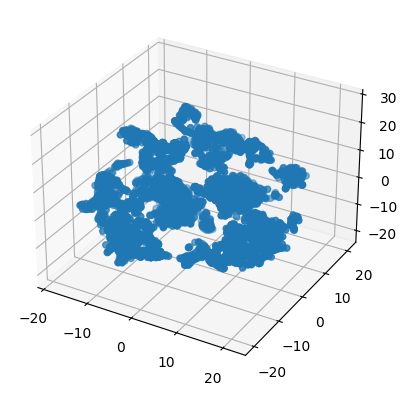

In [119]:
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2]);

In [120]:
test_reg(X_tsne, y_reg)

MSE: 659501.5860996696
R^2: 0.2026657729167436


In [125]:
isomap = Isomap(n_components=5)
X_isomap = isomap.fit_transform(X_scaled)

test_reg(X_isomap, y_reg)

c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 12 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a cs

MSE: 638476.9944000955
R^2: 0.28022456594241685


Нелинейные модели плохо справились с регрессией...

### Обучение модели с использованием данных в пространстве низкой размерности 

Возьмем данные, получившиеся в результате рекурсивного отбора признаков

In [126]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_rfe, y_reg, test_size=0.2, random_state=0)

X_train_reg.shape, y_train_reg.shape, X_test_reg.shape, y_test_reg.shape

((4216, 3), (4216,), (1055, 3), (1055,))

In [127]:
import xgboost as xg

xgb_r = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, max_depth=6, eta=0.2) 

xgb_r.fit(X_train_reg, y_train_reg) 

c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10,
             n_jobs=None, num_parallel_tree=None, ...)

In [130]:
pred = xgb_r.predict(X_test_reg) 

print('MSE:', mean_squared_error(y_test_reg, pred))
print('R2:', r2_score(y_test_reg, pred))

MSE: 269890.4961231423
R2: 0.6900702162813652


Хорошо получилось)

## Собственная реализация PCA

In [27]:
import numpy as np

class PCA:
    def __init__(self, n_components: int):
        self.n_components = n_components

    def fit_transform(self, X: np.ndarray):
        # нормализация признаков
        X_norm = (X - X.mean(axis=0))/X_clf.std(axis=0)
        cov_matrix = np.cov(X_norm.T)

        # из COV_MATRIX вычисляются собственные векторы и собственные значения
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # сортируются собственные значения и собственные векторы в порядке убывания
        eig_pairs = [(eigenvalues[index],eigenvectors[:,index]) for index in range(len(eigenvalues))]
        eig_pairs.sort()
        eig_pairs.reverse()

        # извлекаются отсортированные собственные значения и собственные векторы
        eigenvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]
        vect = np.array(eigenvectors_sorted) 

        # dot product to create principal components analysis
        X_vect_pca = np.dot(X_norm, vect.T)[:, :self.n_components]

        return X_vect_pca

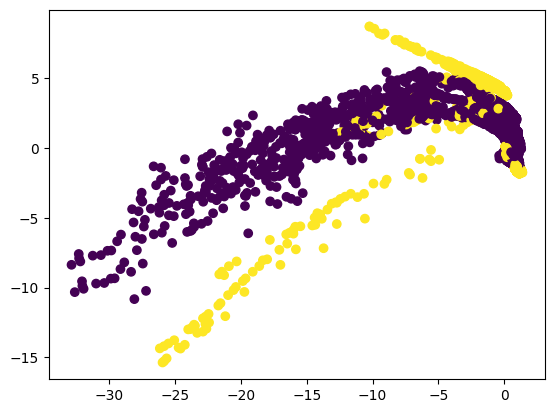

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clf)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_clf);

In [29]:
test_clf(X_pca, y_clf)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3462
           1       0.98      0.98      0.98      3462

    accuracy                           0.98      6924
   macro avg       0.98      0.98      0.98      6924
weighted avg       0.98      0.98      0.98      6924

[[3392   70]
 [  80 3382]]
